In [14]:
import os
import numpy as np
from PIL import Image
import sys

os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
sys.stderr = stderr


digits = []

img_rows, img_cols = 28, 28
LEXICON = "0123456789abcdefghijklmnopqrstuvwxyz"
num_classes = len(LEXICON)
input_shape = (img_rows, img_cols, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.load_weights("recognizer.h5")


def first_element(val):
    return val[0]

def merge_boxes(b1, b2):
    b1_xa, b1_ya, b1_w, b1_h = b1[0], b1[1], b1[2], b1[3]
    b2_xa, b2_ya, b2_w, b2_h = b2[0], b2[1], b2[2], b2[3]
    b1_xb, b1_yb = b1_xa + b1_w, b1_ya + b1_h
    b2_xb, b2_yb = b2_xa + b2_w, b2_ya + b2_h
    
    xa = min(b1_xa, b2_xa)
    ya = min(b1_ya, b2_ya)
    xb = max(b1_xb, b2_xb)
    yb = max(b1_yb, b2_yb)
    w = xb - xa
    h = yb - ya
    return [xa, ya, w, h]
    
def merge_bounding_boxes(bounding_boxes):
    i = 1
    res_boxes = []
    skip_box = False
    for box in bounding_boxes[1:]:
        prev_box = bounding_boxes[i - 1]
        if (prev_box[0] == box[0]) or (prev_box[0] + prev_box[2]) == (box[0] + box[2]):
            res_boxes.append(merge_boxes(prev_box, box))
            skip_box = True
        else:
            if not skip_box:
                res_boxes.append(prev_box)
            skip_box = False
        i = i + 1
    if not skip_box:
        res_boxes.append(bounding_boxes[i - 1])
    return res_boxes

def split_large_bounding_boxes(bounding_boxes):
    res = []
    for box in bounding_boxes:
        if box[2] > 23:
            b1 = box.copy()
            b2 = box.copy()
            b1[2] = int(b1[2] / 2)
            b2[2] = int(b2[2] / 2)
            res.append(b1)
            res.append(b2)
        else:
            res.append(box)
    return res

def padded(image, target_w, target_h):
    h, w = image.shape[:2]
    if w < target_w or h < target_h:
        extra_w = int((target_w - w)/2)
        extra_w_1 = target_w - w - extra_w
        extra_h = int((target_h - h)/2)
        extra_h_1 = target_h - h - extra_h
        padded = cv2.copyMakeBorder(image, extra_h, extra_h_1, extra_w, extra_w_1, cv2.BORDER_CONSTANT, value=[255,255,255])        
        return padded
    else:
        return image

def split_image(image):
    print(image.shape)
    if (image.shape[0] == 60 and image.shape[1] == 240):
        image = cv2.resize(image, (120, 30))
        print("resize")
    print(image.shape)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_border = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_CONSTANT, value=[0,0,0])
    binarized = cv2.threshold(gray_border, 50, 255, cv2.THRESH_BINARY_INV, cv2.THRESH_OTSU)[1]
    contours, hierarchies = cv2.findContours(binarized, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    index = 0 
    letters = []
    bounding_boxes = []
    for contour in contours:
        hr = hierarchies[0][index]
        x, y, w, h = cv2.boundingRect(contour)

        if (hr[3] == 0):
            print(hr)
            print(x,y,w,h)
            bounding_boxes.append([x, y, w, h])    
        index = index +1
        
    bounding_boxes.sort(key=first_element)        
    bounding_boxes = merge_bounding_boxes(bounding_boxes)
    bounding_boxes = split_large_bounding_boxes(bounding_boxes)
    if len(bounding_boxes) > 6:
        print(bounding_boxes)
    
    for box in bounding_boxes:
        global digits
        x, y, w, h = box[0], box[1], box[2], box[3]
        crop_img = binarized[y:y+h, x:x+w]
        print("crop")
        display(Image.fromarray(crop_img))
        digits.append(padded(crop_img, 28, 28))
        letters.append(padded(crop_img, 28, 28))
            
    return letters

In [15]:
import cv2
image = cv2.imread("disorganized/1vugwj.jpg")

digit_images = split_image(image)



s = ""
for digit in digit_images:
    res = model.predict(digit.reshape(1, 28, 28, 1))
    s = s + LEXICON[res.argmax(1)[0]]
    
print(s)

(30, 120, 3)
(30, 120, 3)
[ 2 -1 -1  0]
94 13 11 21
[ 3  1 -1  0]
75 13 23 16
[5 2 4 0]
59 13 15 21
[ 6  3 -1  0]
43 13 14 16
[ 7  5 -1  0]
26 13 16 16
[ 8  6 -1  0]
99 8 6 5
[-1  7 -1  0]
12 8 14 21
crop


crop


crop


crop


crop


crop


1vugwj


In [16]:
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

classifier = model



In [50]:
layer_outputs = [layer.output for layer in classifier.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(digits[5].reshape(1, 28, 28, 1))

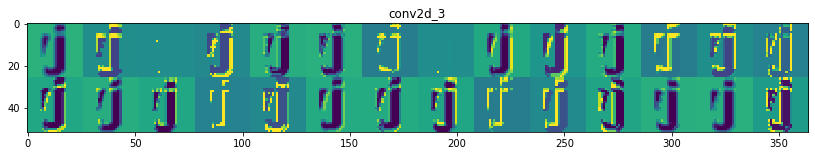

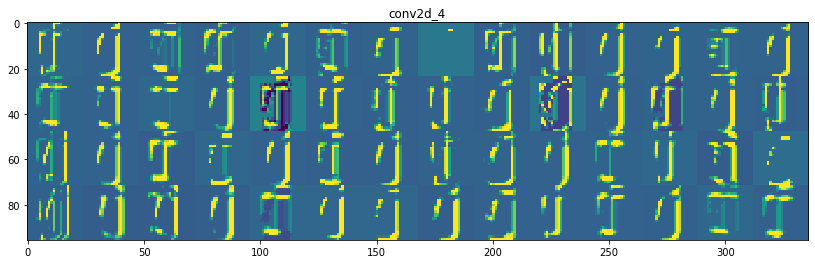

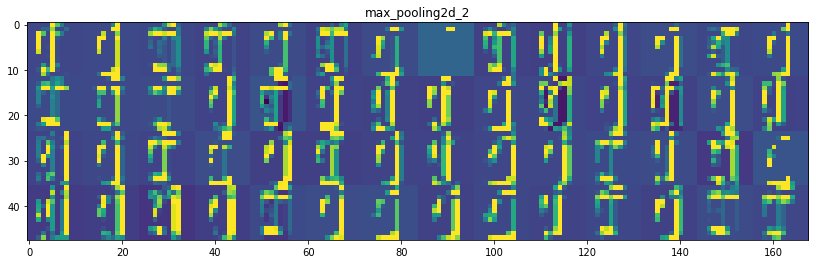

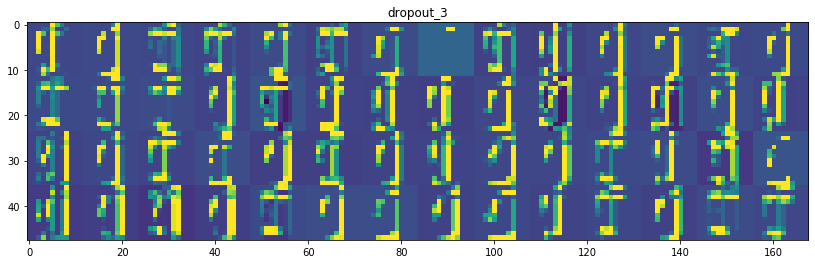

In [65]:
layer_names = []
for layer in classifier.layers[:5]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 28//2

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    if len(layer_activation.shape) == 4:
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


In [66]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              